In [2]:
# Import the modules
from sklearn.externals import joblib
from sklearn import datasets
from skimage.feature import hog
from sklearn.svm import LinearSVC
import numpy as np
from collections import Counter
%matplotlib inline
import cv2
import matplotlib.pyplot as plt 
import collections

def invert(image):
    return 255-image

In [2]:
# Load the dataset
dataset = datasets.fetch_mldata("MNIST Original")
#dataset=joblib.load("digits_cls.pkl")
# Extract the features and labels
features = np.array(dataset.data, 'int16') 
labels = np.array(dataset.target, 'int')


# Extract the hog features
list_hog_fd = []
for feature in features:
    fd = hog(feature.reshape((28, 28)), orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1, 1), visualise=False)
    list_hog_fd.append(fd)
hog_features = np.array(list_hog_fd, 'float64')

print "Count of digits in dataset", Counter(labels)

# Create an linear SVM object
clf = LinearSVC()

# Perform the training
clf.fit(hog_features, labels)

# Save the classifier
joblib.dump(clf, "digits_cls.pkl", compress=3)

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
Count of digits in dataset Counter({1: 7877, 7: 7293, 3: 7141, 2: 6990, 9: 6958, 0: 6903, 6: 6876, 8: 6825, 4: 6824, 5: 6313})


['digits_cls.pkl']

05221859


-1

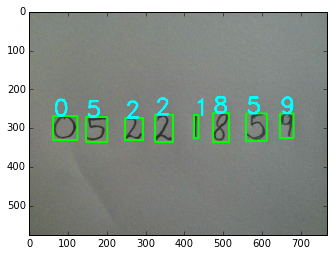

In [3]:
# Load the classifier
clf = joblib.load("digits_cls.pkl")

#print(clf)

# Read the input image 
im = cv2.imread("images//photo_1.jpg")
#im = cv2.imread("IMG_20160113_124542.jpg")
#im = cv2.imread("IMG_20160121_121129.jpg")
im=cv2.resize(im,(768,576))

# Convert to grayscale and apply Gaussian filtering
im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
im_gray = cv2.GaussianBlur(im_gray, (5, 5), 0)

height, width = im_gray.shape
image_bin = np.ndarray((height, width), dtype=np.uint8)

# Threshold the image
#ret, im_th = cv2.threshold(im_gray, 90, 255, cv2.THRESH_BINARY_INV)
im_th=cv2.adaptiveThreshold(im_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 35, 20)


kernele = np.ones((3,3)) # strukturni element 3x3 blok
kerneld = np.ones((3,3))
kernele2 = np.ones((6,6)) # strukturni element 3x3 blok

im_th=cv2.erode(im_th, kernele, iterations=1)
im_th=cv2.dilate(im_th, kerneld, iterations=1)
im_th=cv2.erode(im_th, kernele2, iterations=1)
#im_th=cv2.erode(im_th, kernele2, iterations=1)
im_th=cv2.dilate(im_th, kerneld, iterations=1)
im_th=cv2.erode(im_th, kernele2, iterations=1)
im_th=cv2.dilate(im_th, kerneld, iterations=1)
im_th=cv2.dilate(im_th, kerneld, iterations=1)
im_th=invert(im_th)
# Find contours in the image

img,ctrs, hier = cv2.findContours(im_th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Get rectangles contains each contour
#rects = [cv2.boundingRect(ctr) for ctr in ctrs]

result={}
sorted_num=[]
# For each rectangular region, calculate HOG features and predict
# the digit using Linear SVM.
numbers={}

for cont in ctrs:
    x,y,w,h=cv2.boundingRect(cont)
    # Draw the rectangles
    cv2.rectangle(im, (x, y), (x + w, y + h), (0, 255, 0), 3) 
    # Make the rectangular region around the digit
    leng = int(h * 1.6)
    pt1 = int(y + h // 2 - leng // 2)
    pt2 = int(x + w // 2 - leng // 2)
    roi = im_th[pt1:pt1+leng, pt2:pt2+leng]
    # Resize the image
    roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
    roi = cv2.dilate(roi, (3, 3))
   
    # Calculate the HOG features
    roi_hog_fd = hog(roi, orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1, 1), visualise=False)
    nbr = clf.predict(np.array([roi_hog_fd], 'float64'))
    numbers[x]=int(nbr)
    cv2.putText(im, str(nbr[0]), (x, y),cv2.FONT_HERSHEY_DUPLEX, 2, (0, 255, 255), 3)

for key in sorted(numbers.iterkeys()):
    sorted_num.append(numbers[key])
print "".join([str(x) for x in sorted_num] )
#cv2.imshow("svd",im)
plt.imshow(im)
cv2.waitKey()